In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.regression.linear_model import OLS
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor


%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

In [2]:
# Definições das funções

# Gráfico de correlação campos Nan. Lista somente as colunas que possuem dados Nan
def null_correlation(df):
    corr = df.isnull().corr()
    cols = corr.columns[corr.count()>0]
    corr = corr.loc[cols, cols]
    cmap=sns.diverging_palette(20, 220, n=200)
    mask = np.triu(np.ones(corr.shape)).astype(np.bool)  #constrói em forma triangular
    sns.heatmap(corr, cmap = cmap,mask=mask, annot=True,vmin=-1, vmax=1,  fmt='.2f') #duas casas decimais
    plt.title('Correlação de dados Nan', fontsize=18)
    plt.show()
    
# Dataframe auxiliar com dados do dataframe para visualizar os tipos de dados e a quantidade de dados Nan
def aux_dataframe(df):
    df_aux = pd.DataFrame({
                        'Column': df.columns,
                        'Type': df.dtypes,
                        'Nan': df.isnull().sum()
                        })
    df_aux['Nan_%'] = round(df_aux['Nan']/df.shape[0]*100,2)
    return df_aux

# Análise inicial dados de test

Inicialmente foi analisado os dados de test para entender quais colunas virão e como os dados virão.
A partir desta análise, serão identificadas a priori quais colunas, dos dados de treino, serão exploradas.

In [3]:
test = pd.read_csv('test.csv')

In [4]:
test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,...,80.0,320.0,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,...,NaN,NaN,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,...,0.0,320.0,D,H,H,C,B,A,NaN,A


In [5]:
test.shape

(4576, 47)

In [6]:
# Chamada classe para criação de dataframe auxiliar
test_aux = aux_dataframe(test)

In [7]:
# Lista somente colunas que possuem dados Nan
columns_null = test_aux[test_aux['Nan']!=0].index
test_aux[ test_aux['Nan']!=0]

,Column,Type,Nan,Nan_%
TP_ENSINO,TP_ENSINO,float64,3096,67.66
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,3096,67.66
NU_NOTA_CN,NU_NOTA_CN,float64,1134,24.78
NU_NOTA_CH,NU_NOTA_CH,float64,1134,24.78
NU_NOTA_LC,NU_NOTA_LC,float64,1199,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,1199,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,1199,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,1199,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,1199,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,1199,26.20


In [8]:
columns_null = list(columns_null)   
columns_null.append('NU_INSCRICAO')

In [9]:
# Verifica relação entre presença na prova e a nota Nan
# 0 - Faltou à prova
# 2 - Eliminado na prova

# TP_PRESENCA_CN X NU_NOTA_CN
print(test.loc[test.NU_NOTA_CN.isnull(), 'TP_PRESENCA_CN'].value_counts())
# TP_PRESENCA_CH X NU_NOTA_CH
print(test.loc[test.NU_NOTA_CH.isnull(), 'TP_PRESENCA_CH'].value_counts())
# TP_PRESENCA_LC X NU_NOTA_LC
print(test.loc[test.NU_NOTA_LC.isnull(), 'TP_PRESENCA_LC'].value_counts())

0    1134
Name: TP_PRESENCA_CN, dtype: int64
0    1134
Name: TP_PRESENCA_CH, dtype: int64
0    1195
2       4
Name: TP_PRESENCA_LC, dtype: int64


In [10]:
# Preenchido com 0 as notas que os alunos faltaram ou forma eliminados na prova
col = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC']
for i in col:
    test[i] = test[i].fillna(0)

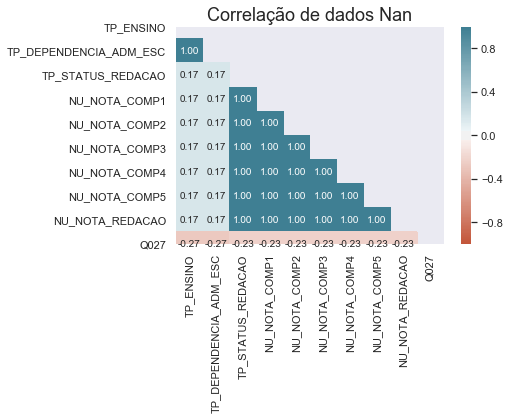

In [11]:
# Chamada a classe criada
# Interpretação do gráfico: 17% dos linhas que possuem NU_NOTA_COMP1 = Nan, possuem TP_ENSINO = Nan
#                           100% das linhas que possuem NU_NOTA_COMP1 = Nan possuem NU_NOTA_COMP2 = Nan  
null_correlation(test)

In [12]:
test.loc[test.NU_NOTA_COMP1.isnull(),columns_null]

,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q027,NU_INSCRICAO
3,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70b682d9a3636be23f6120fa9d6b164eb3c6002d
10,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b7c167ea7b55c8168ec60c3851b1b598a8fbd11
11,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,db4da599aab5bb08dce27094a35fd3e36cd0abce
16,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,fbfa8cde21a692b51fb86342110b4a334a0fcfdb
17,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,ca8477c8493b09f34d17bb287f9bacf2dd744c32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,098eabcd83d72785beca4cdff3d5cfbc71904a48
4546,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,b8ec140a86a7a6e569f3eda9ae9083183ca2e386
4547,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,40a9b86a4efdd7ab5ee6fc26de9a984946896deb
4549,NaN,NaN,419.9,517.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,ec73ba109d1a91299e071b2a95f79c36c1c6e069


In [13]:
#Visualizando os dados de teste, somente para insight
columns_nota = [ 'NU_NOTA_COMP1', 'NU_NOTA_REDACAO',
                'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

In [14]:
test[columns_nota].describe()

,NU_NOTA_COMP1,NU_NOTA_REDACAO,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
count,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000
mean,119.626888,527.491857,111.915902,106.384365,112.881256,76.683447
std,29.028146,151.979490,33.296849,33.834492,33.202244,42.985637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,120.000000,440.000000,100.000000,80.000000,100.000000,40.000000
50%,120.000000,540.000000,120.000000,100.000000,120.000000,80.000000
75%,140.000000,600.000000,120.000000,120.000000,120.000000,100.000000
max,200.000000,980.000000,200.000000,200.000000,200.000000,200.000000


In [15]:
# Chamada classe para criação de dataframe auxiliar
test_aux = aux_dataframe(test)
# Lista somente colunas que possuem dados Nan
test_aux[test_aux['Nan']!=0]

,Column,Type,Nan,Nan_%
TP_ENSINO,TP_ENSINO,float64,3096,67.66
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,3096,67.66
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,1199,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,1199,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,1199,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,1199,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,1199,26.20
NU_NOTA_COMP5,NU_NOTA_COMP5,float64,1199,26.20
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,1199,26.20
Q027,Q027,object,2488,54.37


In [16]:
columns_to_work = list(test_aux.index)

### Dados de treino
Verificando colunas nulas.
Removendo colunas que não fazer parte dos dados de teste.
Preenchendo NU_NOTA_CN e NU_NOTA_CH com a nota média.

In [17]:
treino = pd.read_csv('train.csv')

In [18]:
treino.shape

(13730, 167)

In [19]:
# A coluna TP_PRESENCA_MT não esta presente na base de test, portanto não será
#carregada nos dados de treino. 
#Mas serão removidos todos os registros cujo NU_NOTA_MT seja null, pois estes alunos
#não compareceram ou foram eliminados na prova.
print(treino.loc[treino.NU_NOTA_MT.isnull(), 'TP_PRESENCA_MT'].value_counts())

0    3592
2       5
Name: TP_PRESENCA_MT, dtype: int64


In [20]:
#Dataframe de treino somente com as colunas presente no dataframe de test
columns_to_work.append('NU_NOTA_MT')
treino1 = treino[columns_to_work]

In [21]:
treino1.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,520.0,D,D,C,A,A,C,H,A,399.4
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,580.0,A,A,B,A,A,A,NaN,A,459.8
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,NaN,D,D,C,A,A,A,NaN,A,NaN
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,NaN,H,E,E,C,B,C,F,D,NaN
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,...,NaN,E,D,C,A,A,B,F,A,NaN


In [22]:
# Remove registros com NU_NOTA_MT = 'Nan'
treino1 = treino1.drop(treino1[treino1.NU_NOTA_MT.isnull()].index)

In [23]:
treino1_aux = aux_dataframe(treino1)
treino1_aux[treino1_aux.Nan !=0]

,Column,Type,Nan,Nan_%
TP_ENSINO,TP_ENSINO,float64,6494,64.09
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,6494,64.09
NU_NOTA_CN,NU_NOTA_CN,float64,36,0.36
NU_NOTA_CH,NU_NOTA_CH,float64,36,0.36
Q027,Q027,object,6126,60.46


In [24]:
# Preenche os 36 registros com a média das notas
treino1['NU_NOTA_CN'] = treino1['NU_NOTA_CN'].fillna(treino1['NU_NOTA_CN'].mean())
treino1['NU_NOTA_CH'] = treino1['NU_NOTA_CH'].fillna(treino1['NU_NOTA_CH'].mean())

In [25]:
treino1_aux = aux_dataframe(treino1)
treino1_aux[treino1_aux.Nan!=0]

,Column,Type,Nan,Nan_%
TP_ENSINO,TP_ENSINO,float64,6494,64.09
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,6494,64.09
Q027,Q027,object,6126,60.46


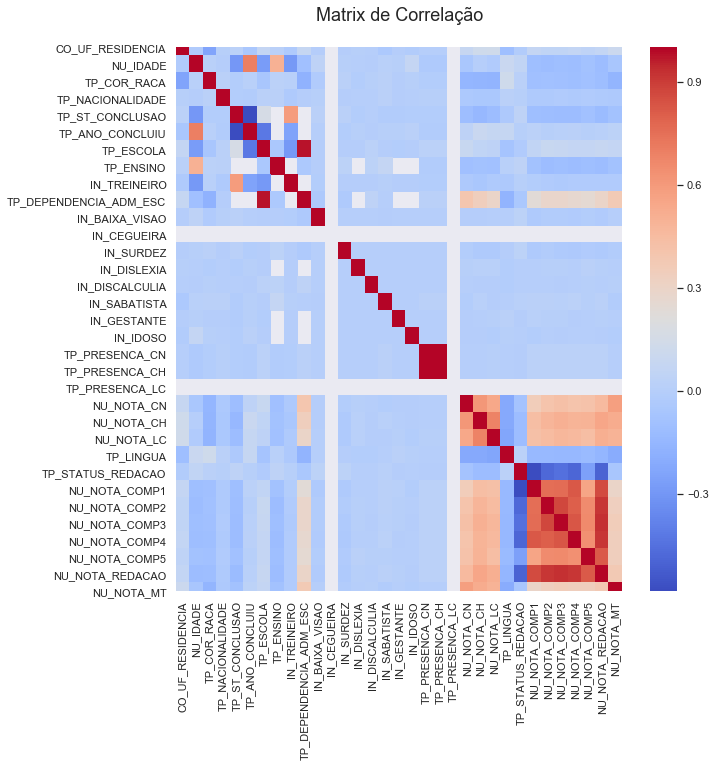

In [26]:
# Visualiza correlação das variáveis numéricas
type_number = treino1.select_dtypes(exclude=[object]).columns
fig, ax = plt.subplots(figsize=(10,10)) 
corr = treino1[type_number].corr()
sns.heatmap(corr, ax=ax,  cmap = 'coolwarm')
plt.title('Matrix de Correlação\n', fontsize=18)
plt.show()

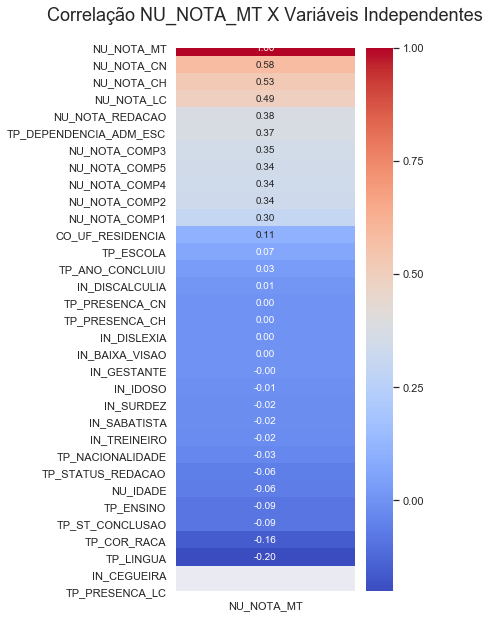

In [27]:
# Visualização detalhada da correlação das variaveis independentes com a variavel target 
plt.figure(figsize(4,10))
cmap=sns.diverging_palette(20, 220, n=200)
sns.heatmap(corr[['NU_NOTA_MT']].sort_values('NU_NOTA_MT',ascending=False),
            cmap = 'coolwarm',
            annot=True,
            fmt='.2f'
           )
plt.title('Correlação NU_NOTA_MT X Variáveis Independentes\n', fontsize=18)
plt.show()

- As variáveis que possuem pouca correlação e que possuem muitos dados nulos não serão utilizados como 
parâmetro no algoritmo de ML

In [28]:
# Juntar os dados de treino e teste para facilitar as transformações
# Nesta junção as NU_NOTA_MT do index test serão NAN
# Cria um dataframe multindex
df = pd.concat([treino1, test], keys=['train', 'test'], sort=True)

In [29]:
df.head()

CO_PROVA_CH  \
train 0  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8   
      1  909237ab0d84688e10c0470e2997348aff585273   
      5  f48d390ab6a2428e659c37fb8a9d00afde621889   
      6  942ab3dc020af4cf53740b6b07e9dd7060b24164   
      7  909237ab0d84688e10c0470e2997348aff585273   

                                      CO_PROVA_CN  \
train 0  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2   
      1  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   
      5  c8328ebc6f3238e06076c481bc1b82b8301e7a3f   
      6  66b1dad288e13be0992bae01e81f71eca1c6e8a6   
      7  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   

                                      CO_PROVA_LC  \
train 0  01af53cd161a420fff1767129c10de560cc264dd   
      1  01af53cd161a420fff1767129c10de560cc264dd   
      5  01abbb7f1a90505385f44eec9905f82ca2a42cfd   
      6  5aebe5cad7fabc1545ac7fba07a4e6177f98483c   
      7  72f80e4b3150c627c7ffc93cfe0fa13a9989b610   

                                      CO_PROVA_MT  CO_UF_RESIDENCIA  \
train 0  97caab1e1533dba217deb7ef41490f52e459ab01                43   
      1  97caab1e1533dba217deb7ef41490f52e459ab01                23   
      5  81d0ee00ef42a7c23eb04496458c03d4c5b9c31a                29   
      6  767a32545304ed293242d528f54d4edb1369f910                51   
      7  577f8968d95046f5eb5cc158608e12fa9ba34c85                43   

         IN_BAIXA_VISAO  IN_CEGUEIRA  IN_DISCALCULIA  IN_DISLEXIA  \
train 0               0            0               0            0   
      1               0            0               0            0   
      5               0            0               0            0   
      6               0            0               0            0   
      7               0            0               0            0   

         IN_GESTANTE  ...  TP_ENSINO  TP_ESCOLA  TP_LINGUA  TP_NACIONALIDADE  \
train 0            0  ...        NaN          1          1                 1   
      1            0  ...        1.0          2          1                 1   
      5            0  ...        NaN          1          0                 1   
      6            0  ...        1.0          2          0                 1   
      7            0  ...        NaN          1          0                 1   

         TP_PRESENCA_CH TP_PRESENCA_CN  TP_PRESENCA_LC  TP_SEXO  \
train 0               1              1               1        M   
      1               1              1               1        F   
      5               1              1               1        F   
      6               1              1               1        F   
      7               1              1               1        F   

         TP_STATUS_REDACAO  TP_ST_CONCLUSAO  
train 0                1.0                1  
      1                1.0                2  
      5                1.0                1  
      6                1.0                2  
      7                1.0                1  

[5 rows x 48 columns]

In [30]:
df.tail()

CO_PROVA_CH  \
test 4571  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8   
     4572  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8   
     4573  909237ab0d84688e10c0470e2997348aff585273   
     4574  942ab3dc020af4cf53740b6b07e9dd7060b24164   
     4575  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                        CO_PROVA_CN  \
test 4571  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2   
     4572  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2   
     4573  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   
     4574  66b1dad288e13be0992bae01e81f71eca1c6e8a6   
     4575  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                        CO_PROVA_LC  \
test 4571  01abbb7f1a90505385f44eec9905f82ca2a42cfd   
     4572  72f80e4b3150c627c7ffc93cfe0fa13a9989b610   
     4573  01af53cd161a420fff1767129c10de560cc264dd   
     4574  72f80e4b3150c627c7ffc93cfe0fa13a9989b610   
     4575  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                        CO_PROVA_MT  CO_UF_RESIDENCIA  \
test 4571  81d0ee00ef42a7c23eb04496458c03d4c5b9c31a                41   
     4572  577f8968d95046f5eb5cc158608e12fa9ba34c85                35   
     4573  97caab1e1533dba217deb7ef41490f52e459ab01                35   
     4574  577f8968d95046f5eb5cc158608e12fa9ba34c85                52   
     4575  2d22ac1d42e6187f09ee6c578df187a760123ccf                33   

           IN_BAIXA_VISAO  IN_CEGUEIRA  IN_DISCALCULIA  IN_DISLEXIA  \
test 4571               0            0               0            0   
     4572               0            0               0            0   
     4573               0            0               0            0   
     4574               0            0               0            0   
     4575               0            0               0            0   

           IN_GESTANTE  ...  TP_ENSINO  TP_ESCOLA  TP_LINGUA  \
test 4571            0  ...        1.0          2          0   
     4572            0  ...        1.0          2          1   
     4573            0  ...        NaN          1          0   
     4574            0  ...        NaN          1          1   
     4575            0  ...        NaN          1          1   

           TP_NACIONALIDADE  TP_PRESENCA_CH TP_PRESENCA_CN  TP_PRESENCA_LC  \
test 4571                 1               1              1               1   
     4572                 1               1              1               1   
     4573                 1               1              1               1   
     4574                 2               1              1               1   
     4575                 1               0              0               0   

           TP_SEXO  TP_STATUS_REDACAO  TP_ST_CONCLUSAO  
test 4571        F                1.0                2  
     4572        M                1.0                2  
     4573        M                1.0                1  
     4574        M                1.0                3  
     4575        M                NaN                1  

[5 rows x 48 columns]

In [31]:
df.xs('test').head()

,CO_PROVA_CH,CO_PROVA_CN,CO_PROVA_LC,CO_PROVA_MT,CO_UF_RESIDENCIA,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_DISCALCULIA,IN_DISLEXIA,IN_GESTANTE,...,TP_ENSINO,TP_ESCOLA,TP_LINGUA,TP_NACIONALIDADE,TP_PRESENCA_CH,TP_PRESENCA_CN,TP_PRESENCA_LC,TP_SEXO,TP_STATUS_REDACAO,TP_ST_CONCLUSAO
0,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,41,0,0,0,0,0,...,NaN,1,0,1,1,1,1,F,1.0,1
1,f48d390ab6a2428e659c37fb8a9d00afde621889,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,21,0,0,0,0,0,...,NaN,1,1,1,1,1,1,F,1.0,1
2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,23,0,0,0,0,0,...,3.0,2,0,1,1,1,1,M,1.0,2
3,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,15,0,0,0,0,0,...,NaN,1,0,1,0,0,0,F,NaN,1
4,942ab3dc020af4cf53740b6b07e9dd7060b24164,66b1dad288e13be0992bae01e81f71eca1c6e8a6,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,41,0,0,0,0,0,...,1.0,2,1,1,1,1,1,M,1.0,2


# Primeira tratativa

- A principio será ignorado as colunas TP_ENSINO, TP_DEPENDENCIA_ADM_ESC e Q027 que possuem mais de 60% de dados Nan na base de treino.
- As colunas 'NU_NOTA_CN' e 'NU_NOTA_CH' com valores Nan foram preenchidos com a media na base de treino.
- As colunas NU_NOTA_COMP na base de teste possuem várias linhas NAN que serão tratadas posteriormente.

### Classe para cálculos de métricas para a regressão linear

In [32]:
def press_statistic(y_true, y_pred, xs):
    res = y_pred - y_true
    hat = xs.dot(np.linalg.pinv(xs))
    den = (1 - np.diagonal(hat))
    sqr = np.square(res/den)
    return sqr.sum()

def predicted_r2(y_true, y_pred, xs):
    # é uma forma de validar com o modelo esta acertando as previsões
    press = press_statistic(y_true=y_true,
                            y_pred=y_pred,
                            xs=xs
    )

    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - press / sst

In [33]:
def adjusted_r2(r2, shape):
    # é uma forma de validar se as variáveis inseridas no modelo estão realmente agregando ao modelo
    # se o valor retornado começar a diminuir com relação a outro modelo, a inserção de novas variáveis 
    #não será mais significativo ao modelo
    adj_r2 = (1 - (1 - r2) * ((shape[0] - 1) / 
          (shape[0] - shape[1] - 1)))
    return adj_r2

## Modelo de Regressão

In [34]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
           'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
           'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']
X = df.xs('train')[colunas] 
y = df.xs('train').NU_NOTA_MT 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=250 )

In [35]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
predict = regr.predict(X_test)

In [37]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict))
print('R2 score: ', r2_score(y_test, predict))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict), X_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict, X_test))

Mean squared error:  6120.077719685536
R2 score:  0.3764465344810358
Adjusted R2: 0.3756186865403851
Predicted R2: 0.37278386753985615


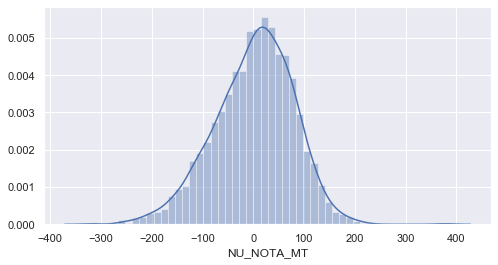

In [38]:
residuos = predict - y_test
plt.figure(figsize=(8,4)) 
sns.distplot(residuos)
plt.show()

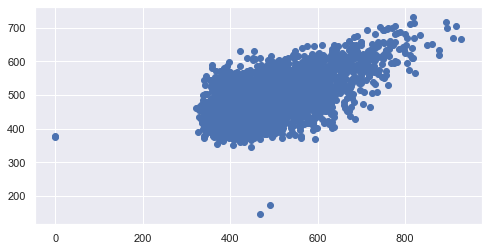

In [39]:
plt.figure(figsize=(8,4))
plt.scatter(x = y_test, y=predict)
plt.show()

### Normalizado os dados

Como os dados estão na mesma unidade, era previsto os resultados iguais. Realizado apenas para aprendizado.

In [40]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)

In [41]:
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)

In [42]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2( r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  6120.077719685534
R2 score:  0.37644653448103593
Adjusted R2: 0.3756186865403852
Predicted R2: 0.3725762367296971


### Padronizando os dados

In [43]:
X_norm = preprocessing.normalize(X)
X_norm_train, X_norm_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=250)
regr_norm = linear_model.LinearRegression()
regr_norm.fit(X_norm_train, y_train)
predict_norm = regr_norm.predict(X_norm_test)

In [44]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict_norm))
print('R2 score: ', r2_score(y_test, predict_norm))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_norm), X_norm_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_norm, X_norm_test))

Mean squared error:  9068.231310370813
R2 score:  0.07606940324936895
Adjusted R2: 0.07484276578502957
Predicted R2: 0.07082336135893452


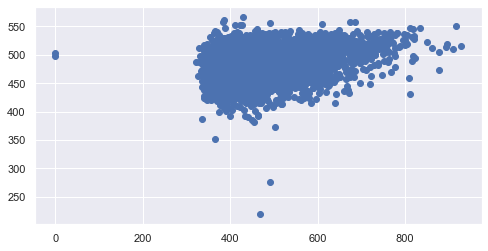

In [45]:
plt.figure(figsize=(8,4)) 
plt.scatter(x = y_test, y=predict_norm)
plt.show()

### Aplicar PCA nos dados normalizados

In [46]:
pca = PCA().fit(X_stand)

Text(0, 0.5, 'cumulative explained variancce')

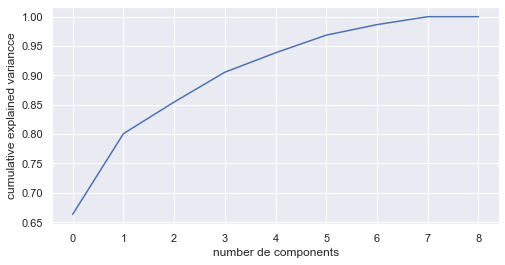

In [47]:
plt.figure(figsize=(8,4)) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number de components')
plt.ylabel('cumulative explained variancce')

In [48]:
X_pca = PCA(n_components=7).fit_transform(X_stand)
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=250)
regr_pca = linear_model.LinearRegression()
regr_pca.fit(X_pca_train, y_train)
predict_pca = regr_pca.predict(X_pca_test)

In [49]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict_pca))
print('R2 score: ', r2_score(y_test, predict_pca))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_pca), X_pca_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_pca, X_pca_test))

Mean squared error:  6117.827501991463
R2 score:  0.37667580134750034
Adjusted R2: 0.3760323461947843
Predicted R2: 0.3731561830470036


### Efetuando algumas transformações

- Inserir idade em range e colocar como colunas Jovens ate 19 anos. Adultos de 20 a 59 e Idosos acima de 60.

In [50]:
bins = [0,20, 60,100]
labels = ['Teen', 'Adult', 'Old']
df['AgeGroup'] = pd.cut(df.NU_IDADE, bins = bins, right=False, labels=labels )

In [51]:
#Cria um novo dataframe com as colunas Age_Teen, Age_Adult, Age_Old
df1 = df.copy()
df1 = pd.concat([df1.drop(['NU_IDADE','AgeGroup'], axis=1), pd.get_dummies(df1['AgeGroup'], prefix='Age')], axis=1)

In [52]:
df1.head()

CO_PROVA_CH  \
train 0  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8   
      1  909237ab0d84688e10c0470e2997348aff585273   
      5  f48d390ab6a2428e659c37fb8a9d00afde621889   
      6  942ab3dc020af4cf53740b6b07e9dd7060b24164   
      7  909237ab0d84688e10c0470e2997348aff585273   

                                      CO_PROVA_CN  \
train 0  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2   
      1  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   
      5  c8328ebc6f3238e06076c481bc1b82b8301e7a3f   
      6  66b1dad288e13be0992bae01e81f71eca1c6e8a6   
      7  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   

                                      CO_PROVA_LC  \
train 0  01af53cd161a420fff1767129c10de560cc264dd   
      1  01af53cd161a420fff1767129c10de560cc264dd   
      5  01abbb7f1a90505385f44eec9905f82ca2a42cfd   
      6  5aebe5cad7fabc1545ac7fba07a4e6177f98483c   
      7  72f80e4b3150c627c7ffc93cfe0fa13a9989b610   

                                      CO_PROVA_MT  CO_UF_RESIDENCIA  \
train 0  97caab1e1533dba217deb7ef41490f52e459ab01                43   
      1  97caab1e1533dba217deb7ef41490f52e459ab01                23   
      5  81d0ee00ef42a7c23eb04496458c03d4c5b9c31a                29   
      6  767a32545304ed293242d528f54d4edb1369f910                51   
      7  577f8968d95046f5eb5cc158608e12fa9ba34c85                43   

         IN_BAIXA_VISAO  IN_CEGUEIRA  IN_DISCALCULIA  IN_DISLEXIA  \
train 0               0            0               0            0   
      1               0            0               0            0   
      5               0            0               0            0   
      6               0            0               0            0   
      7               0            0               0            0   

         IN_GESTANTE  ...  TP_NACIONALIDADE  TP_PRESENCA_CH  TP_PRESENCA_CN  \
train 0            0  ...                 1               1               1   
      1            0  ...                 1               1               1   
      5            0  ...                 1               1               1   
      6            0  ...                 1               1               1   
      7            0  ...                 1               1               1   

         TP_PRESENCA_LC TP_SEXO  TP_STATUS_REDACAO  TP_ST_CONCLUSAO  Age_Teen  \
train 0               1       M                1.0                1         0   
      1               1       F                1.0                2         1   
      5               1       F                1.0                1         1   
      6               1       F                1.0                2         1   
      7               1       F                1.0                1         1   

         Age_Adult  Age_Old  
train 0          1        0  
      1          0        0  
      5          0        0  
      6          0        0  
      7          0        0  

[5 rows x 50 columns]

- Aplicação do modelo com as colunas de Age com dados com StandardScaler

Verifique que a Predicted R2 piorou muito com a inserção desta variável. Então optou-se por removê-la do 
modelo e seguir com os testes

In [53]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
           'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
           'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Age_Teen', 'Age_Adult', 'Age_Old']
X = df1.xs('train')[colunas]
y = df1.xs('train').NU_NOTA_MT

In [54]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  6116.383680229051
R2 score:  0.37682290733287827
Adjusted R2: 0.3757192879243769
Predicted R2: -28.430087139900714


- Colocar regioes norte, nordeste, centro-oeste, sul e sudeste com SG_UF_RESIDENCIA

In [55]:
# Optou-se por não incluir a Age no df1 devido a piora na previsão do modelo
df1 = df.copy()

In [56]:
Norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
Nordeste = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
Centro_oeste = ['MT', 'MS', 'GO', 'DF']
Sudeste = ['SP', 'RJ', 'ES', 'MG']
Sul = ['PR', 'RS', 'SC']

In [57]:
def regiao(uf):
    if uf in Norte:
        return('Norte')
    elif uf in Nordeste:
        return('Nordeste')
    elif uf in Centro_oeste:
        return('Centro_oeste')
    elif uf in Sudeste:
        return('Sudeste')    
    else:
        return('Sul')

df1['Regiao'] = df1['SG_UF_RESIDENCIA'].apply(regiao)  

In [58]:
df1 = pd.concat([df1.drop(['SG_UF_RESIDENCIA','Regiao'], axis=1), pd.get_dummies(df1['Regiao'], prefix='Regiao')], axis=1)

In [59]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO',
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul'
          ]
X = df1.xs('train')[colunas]
y = df1.xs('train')['NU_NOTA_MT']

In [60]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  6114.398228464262
R2 score:  0.37702519811826696
Adjusted R2: 0.3757376800748149
Predicted R2: 0.37159410657986414


- Colocar sexo com TP_SEXO

In [61]:
df1 = pd.concat([df1.drop(['TP_SEXO'], axis=1), pd.get_dummies(df1['TP_SEXO'], prefix='Sexo')], axis=1)

In [62]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul', 'Sexo_F', 'Sexo_M'
          ]
X = df1.xs('train')[colunas]
y = df1.xs('train')['NU_NOTA_MT']

In [63]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  5997.502084068397
R2 score:  0.38893534032273425
Adjusted R2: 0.38749159629514474
Predicted R2: 0.38326465896320927


- Colocar raças TP_COR_RACA

In [64]:
df1 = pd.concat([df1.drop(['TP_COR_RACA'], axis=1), pd.get_dummies(df1['TP_COR_RACA'], prefix='Raca')], axis=1)

In [65]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul', 'Sexo_F', 'Sexo_M', 'Raca_0', 'Raca_1', 'Raca_2', 'Raca_3', 
        'Raca_4', 'Raca_5'
          ]
X = df1.xs('train')[colunas]
y = df1.xs('train')['NU_NOTA_MT']

In [66]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  5965.604739981838
R2 score:  0.39218524994104653
Adjusted R2: 0.39020890874960446
Predicted R2: 0.38455158894900043


- Incluir Situação de conclusão do Ensino Médio com TP_ST_CONCLUSAO

In [67]:
df1 = pd.concat([df1.drop(['TP_ST_CONCLUSAO'], axis=1), pd.get_dummies(df1['TP_ST_CONCLUSAO'], prefix='Concl')], axis=1)

In [68]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO',
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul', 'Sexo_F', 'Sexo_M', 'Raca_0', 'Raca_1', 'Raca_2', 'Raca_3', 
        'Raca_4', 'Raca_5', 'Concl_1', 'Concl_2', 'Concl_3', 'Concl_4'
          ]
X = df1.xs('train')[colunas]
y = df1.xs('train')['NU_NOTA_MT']

In [69]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  5971.979015038861
R2 score:  0.3915357971915834
Adjusted R2: 0.3891962424336688
Predicted R2: 0.38278233456553423


- Incluir Residência tem acesso a internet Q025

In [70]:
df1 = pd.concat([df1.drop(['Q025'], axis=1), pd.get_dummies(df1['Q025'], prefix='Q025')], axis=1)

In [71]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul', 'Sexo_F', 'Sexo_M', 'Raca_0', 'Raca_1', 'Raca_2', 'Raca_3', 
        'Raca_4', 'Raca_5', 'Concl_1', 'Concl_2', 'Concl_3', 'Concl_4', 'Q025_A', 'Q025_B'
          ]
X = df1.xs('train')[colunas]
y = df1.xs('train')['NU_NOTA_MT']

In [72]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  5955.372561547201
R2 score:  0.3932277710682217
Adjusted R2: 0.39071451331524976
Predicted R2: 0.38413948733904413


- Incluir 'Em que tipo de escola você frequentou o Ensino Médio' com Q047

Devido a queda na previsão dos dados quando incluiu-se "Situação da Conclusão do Ensino Médio". Foi removido esta variável.

In [73]:
df1 = pd.concat([df1.drop(['Q047'], axis=1), pd.get_dummies(df1['Q047'], prefix='Q047')], axis=1)

In [74]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul', 'Sexo_F', 'Sexo_M', 'Raca_0', 'Raca_1', 'Raca_2', 'Raca_3', 
        'Raca_4', 'Raca_5',  'Q025_A', 'Q025_B',
        'Q047_A', 'Q047_B','Q047_C', 'Q047_D', 'Q047_E',
          ]
X = df1.xs('train')[colunas]
y = df1.xs('train')['NU_NOTA_MT']

In [75]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  5878.453667777996
R2 score:  0.40106477003628993
Adjusted R2: 0.3984949931951969
Predicted R2: 0.39100361431089314


- Detectar outliers

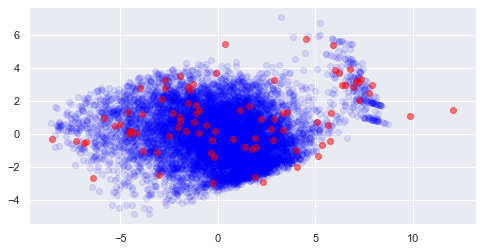

In [76]:
plt.figure(figsize(8,4))
# Utilizando as configurações abaixo para validar a precisão: n_neighbors=20
detector_outlier = LocalOutlierFactor(novelty=True, contamination=0.01).fit(X_stand)
predict_outlier = detector_outlier.predict(X_stand)==-1

#transforma em dados de treino em 2 componentes para faciliar a visualização
pca_outlier = PCA(n_components=2).fit(X_stand)

train_points = pca_outlier.transform(X_stand[~predict_outlier])
plt.scatter(train_points[:, 0], train_points[:, 1], c='blue', alpha=0.1)


outliers = pca_outlier.transform(X_stand[predict_outlier])
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', alpha=0.5);

plt.show()

In [77]:
#Serão removidos 0,85% de dados identificados como outliers
len(predict_outlier[predict_outlier == True])/predict_outlier.shape[0] *100

0.8487121286884437

In [78]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul', 'Sexo_F', 'Sexo_M', 'Raca_0', 'Raca_1', 'Raca_2', 'Raca_3', 
        'Raca_4', 'Raca_5',  'Q025_A', 'Q025_B',
        'Q047_A', 'Q047_B','Q047_C', 'Q047_D', 'Q047_E',
          ]
X = df1.xs('train')[colunas]
y = df1.xs('train')['NU_NOTA_MT']
X = X[~predict_outlier]
y = y[~predict_outlier]

In [79]:
X_stand = preprocessing.StandardScaler(). fit_transform(X)
X_stand_train, X_stand_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.33, random_state=250)
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_train)
predict_stand = regr_stand.predict(X_stand_test)
print('Mean squared error: ' ,mean_squared_error(y_test, predict_stand))
print('R2 score: ', r2_score(y_test, predict_stand))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_stand), X_stand_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_stand, X_stand_test))

Mean squared error:  5629.468375561478
R2 score:  0.44053049354298524
Adjusted R2: 0.43810927048862724
Predicted R2: 0.43204884381064734


- Aplicar PCA

In [80]:
pca = PCA().fit(X_stand)

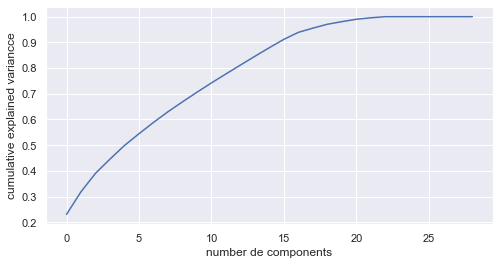

In [81]:
plt.figure(figsize=(8,4)) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number de components')
plt.ylabel('cumulative explained variancce')
plt.show()

In [82]:
X_pca = PCA(n_components=20).fit_transform(X_stand)
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=250)
regr_pca = linear_model.LinearRegression()
regr_pca.fit(X_pca_train, y_train)
predict_pca = regr_pca.predict(X_pca_test)

In [83]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict_pca))
print('R2 score: ', r2_score(y_test, predict_pca))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_pca), X_pca_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_pca, X_pca_test))

Mean squared error:  5625.647829763892
R2 score:  0.44091018816584704
Adjusted R2: 0.4392437505746871
Predicted R2: 0.433428675578558


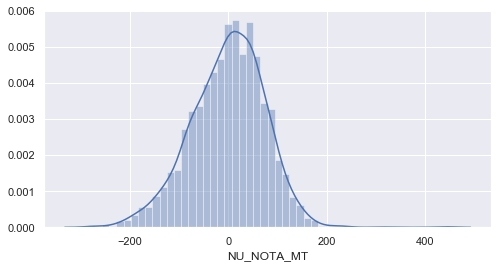

In [84]:
plt.figure(figsize=(8,4)) 
residuos = predict_pca - y_test
sns.distplot(residuos)
plt.show()

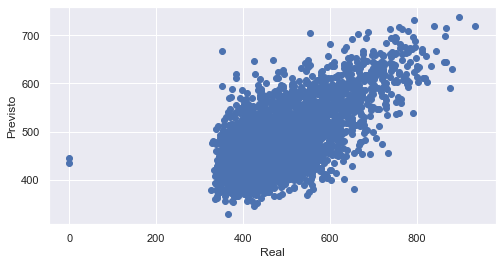

In [85]:
plt.figure(figsize=(8,4)) 
plt.scatter(x = y_test, y=predict_pca)
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.show()

### GridSearchCV

Utilizando GridSearchCV no melhor modelo até o momento

In [86]:
parms = {'fit_intercept': [True, False],
        'normalize': [True, False],
        }
metricas = ['neg_mean_absolute_error', 'neg_mean_squared_error',   'r2']


In [87]:
# Busca os melhores parâmetros com cv=3(default) para todos as métricas definida a cima
grid_Search = GridSearchCV(regr_pca, param_grid=parms, scoring=metricas,
                          refit='neg_mean_squared_error', return_train_score=False, cv=50)

In [88]:
grid_Search = grid_Search.fit(X_pca_train, y_train)

C:\Users\yukik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [89]:
# Considerando o refit='neg_mean_squared_error'
grid_Search.best_score_

-5513.078046242197

In [90]:
#A regressão esta dando um erro médio de 74,29
np.sqrt(grid_Search.best_score_*-1)

74.25010468842584

In [91]:
# A melhor combinação é a definida abaixo
grid_Search.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
pd.DataFrame(grid_Search.cv_results_).iloc[:,7:]

,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,...,split43_test_r2,split44_test_r2,split45_test_r2,split46_test_r2,split47_test_r2,split48_test_r2,split49_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,-58.060917,-61.031764,-62.833928,-54.996461,-64.943532,-53.283943,-47.245629,-63.004013,-58.551481,-66.512124,...,0.419438,0.488118,0.545750,0.404562,0.427306,0.300044,0.442264,0.409162,0.105282,2
1,-58.060917,-61.031764,-62.833928,-54.996461,-64.943532,-53.283943,-47.245629,-63.004013,-58.551481,-66.512124,...,0.419438,0.488118,0.545750,0.404562,0.427306,0.300044,0.442264,0.409162,0.105282,1
2,-475.907116,-488.798321,-488.148048,-490.092204,-479.457015,-485.130144,-489.211902,-478.657091,-485.181882,-479.961371,...,-21.411482,-22.300374,-19.438256,-24.116495,-24.856080,-24.451049,-23.784883,-24.814086,4.369198,3
3,-475.907116,-488.798321,-488.148048,-490.092204,-479.457015,-485.130144,-489.211902,-478.657091,-485.181882,-479.961371,...,-21.411482,-22.300374,-19.438256,-24.116495,-24.856080,-24.451049,-23.784883,-24.814086,4.369198,3


In [93]:
# A primeira 0 é a melhor candidata
grid_Search.best_index_

1

In [94]:
best_reg = grid_Search.best_estimator_
predict_grid = best_reg.predict(X_pca_test)

In [95]:
print('Mean squared error: ' ,mean_squared_error(y_test, predict_grid))
print('R2 score: ', r2_score(y_test, predict_grid))
print('Adjusted R2:', adjusted_r2(r2_score(y_test, predict_grid), X_pca_train.shape) )
print('Predicted R2:', predicted_r2(y_test, predict_grid, X_pca_test))

Mean squared error:  5625.647829763892
R2 score:  0.44091018816584704
Adjusted R2: 0.4392437505746871
Predicted R2: 0.433428675578558


## Tratamento test.csv

In [96]:
# Entendimento da relação das notas para verificar a possibilidade de inserir a mean() aos dados Nan
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']

C:\Users\yukik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


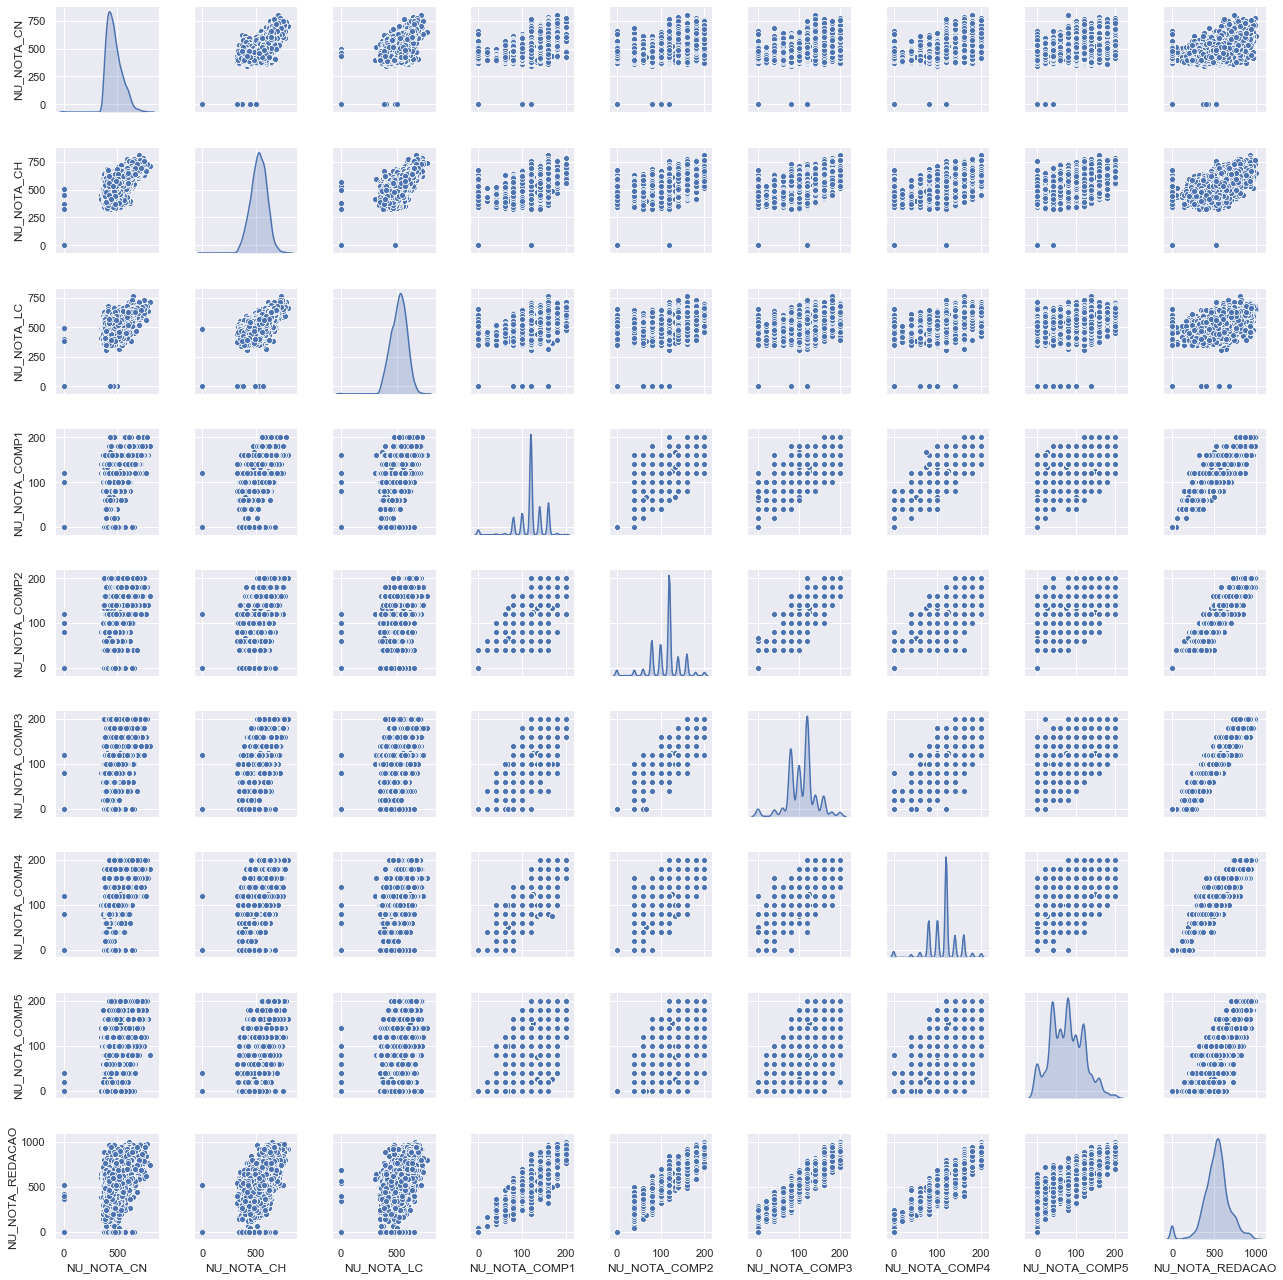

In [97]:
sns.set()
sns.pairplot(df1.xs('train')[colunas], size=2, kind='scatter', diag_kind='kde')
plt.show()

In [98]:
# Optou-se por colocar a média das notas da base de treino na base de test
colunas = [ 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']
mean_train = df1.xs('train')[colunas].mean()
mean_train

NU_NOTA_COMP1      119.811704
NU_NOTA_COMP2      111.915918
NU_NOTA_COMP3      106.824238
NU_NOTA_COMP4      113.123951
NU_NOTA_COMP5       77.372446
NU_NOTA_REDACAO    529.048258
dtype: float64

# Arquivo para submissão

Colunas utilizadas colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul', 'Sexo_F', 'Sexo_M', 'Raca_0', 'Raca_1', 'Raca_2', 'Raca_3', 
        'Raca_4', 'Raca_5',  'Q025_A', 'Q025_B',
        'Q047_A', 'Q047_B','Q047_C', 'Q047_D', 'Q047_E']

- Os dados (notas) que estavam Nan na base de test foram substituidas pela média. Dados foram transformados PCA e GridSearchCV sem remover os outliers Score 75.8%

- Os dados (notas) que estavam Nan na base de test foram substituidas pela média. Dados foram transformados PCA e GridSearchCV remover os outliers Score 75.218%

- Os dados (notas) que estavam Nan na base de test foram substituidas por zero. Dados foram transformados PCA e GridSearchCV remover os outliers. Score: 68.5% 

- Os dados (notas) que estavam Nan na base de test foram substituidas por zero. Dados foram transformados PCA e GridSearchCV remover os outliers Score 69.18% 


In [99]:
colunas = [ 'NU_NOTA_CN','NU_NOTA_CH', 'NU_NOTA_LC',
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
        'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 
        'Regiao_Centro_oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste',
        'Regiao_Sul', 'Sexo_F', 'Sexo_M', 'Raca_0', 'Raca_1', 'Raca_2', 'Raca_3', 
        'Raca_4', 'Raca_5',  'Q025_A', 'Q025_B',
        'Q047_A', 'Q047_B','Q047_C', 'Q047_D', 'Q047_E']

df_entrega = df1.xs('test')[colunas]

In [100]:
# Preenche dados Nan com a média da base de treino
#df_entrega1 = df1.xs('test')[colunas].fillna(mean_train)

# Preenche dados Nan com a média da base de treino
df_entrega1 = df1.xs('test')[colunas].fillna(0)

# Padroniza os dados
df_entrega1_stand = preprocessing.StandardScaler(). fit_transform(df_entrega1)

# Trasforma em PCA
df_entrega1_pca = PCA(n_components=20).fit_transform(df_entrega1_stand)

modelo_preds = grid_Search.predict(df_entrega1_pca)

In [101]:
df_submit = pd.DataFrame({
    'NU_INSCRICAO':df1.xs('test').NU_INSCRICAO,
    'NU_NOTA_MT':modelo_preds
})
df_submit.to_csv('answer.csv', index=False)